In [1]:
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

2024-03-24 04:20:08.970630: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-24 04:20:08.999778: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-24 04:20:09.402340: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
df = pd.read_parquet('run1.parquet',dtype_backend = 'pyarrow')[['X_jets','y']]

In [3]:
df = df.iloc[:1000]

In [5]:
# Convert to numpy arrays
X = np.stack(df['X_jets'].values)
y = df['y'].values


In [194]:
print(X.shape, y.shape)

(1000, 3, 125, 125) (1000,)


In [ ]:
df = None

In [195]:
# Separate into training, validation, and test data

testLen = 0.2*len(X)
X_train = X[:int(len(X)-testLen)]
y_train = y[:int(len(X)-testLen)]

X_test = X[int(len(X)-testLen):]
y_test = y[int(len(X)-testLen):]

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(800, 3, 125, 125) (200, 3, 125, 125)
(800,) (200,)


In [196]:
# Separate into training and validation data
valLen = 0.2*len(X_train)
print(valLen)

X_valid = X_train[:int(valLen)]
y_valid = y_train[:int(valLen)]

print(X_valid.shape, y_valid.shape)

X_train = X_train[int(valLen):]
y_train = y_train[int(valLen):]

print(X_train.shape, y_train.shape)

160.0
(160, 3, 125, 125) (160,)
(640, 3, 125, 125) (640,)


In [197]:
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(640, 3, 125, 125) (160, 3, 125, 125) (200, 3, 125, 125)
(640,) (160,) (200,)


In [198]:
# Take transpose of X data
X_train = np.transpose(X_train, (0,2,3,1))
X_test = np.transpose(X_test, (0,2,3,1))
X_valid = np.transpose(X_valid, (0,2,3,1))

print(X_train.shape, X_valid.shape, X_test.shape)

(640, 125, 125, 3) (160, 125, 125, 3) (200, 125, 125, 3)


In [199]:
# Normalizing the data
mean = np.mean(X_train, axis=(0,1,2,3))
std = np.std(X_train, axis=(0,1,2,3))

In [200]:
X_train = (X_train - mean) / (std + 1e-7)
X_valid = (X_valid - mean) / (std + 1e-7)
X_test = (X_test - mean) / (std + 1e-7)

In [201]:
# Import necessary libraries
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras import regularizers, optimizers


In [202]:
# Build Model Structure (Modified Version Of Alexnet)
base_hidden_units = 32
weight_decay = 1e-4
model = Sequential()

In [203]:
from skimage.transform import resize

# Resize all images to 32,32 in X_train
X_train = np.array([resize(image, (32,32)) for image in X_train])
X_valid = np.array([resize(image, (32,32)) for image in X_valid])
X_test = np.array([resize(image, (32,32)) for image in X_test])

print(X_train.shape, X_valid.shape, X_test.shape)

(640, 32, 32, 3) (160, 32, 32, 3) (200, 32, 32, 3)


In [204]:
print(y_train.shape, y_valid.shape, y_test.shape)

(640,) (160,) (200,)


In [205]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, 2)
y_valid = to_categorical(y_valid, 2)
y_test = to_categorical(y_test, 2)

In [206]:
# Convolutional Layer 1
model.add(Conv2D(base_hidden_units, kernel_size=(3,3),padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Convolutional Layer 2
model.add(Conv2D(base_hidden_units,kernel_size=(3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Pool + Dropout
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#Convolutional Layer 3
model.add(Conv2D(base_hidden_units*2, kernel_size=(3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

#Convolutional Layer 4
model.add(Conv2D(base_hidden_units*2, kernel_size=(3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Pool + Dropout
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

#Convolutional Layer 5
model.add(Conv2D(base_hidden_units*4, kernel_size=(3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

#Convolutional Layer 6
model.add(Conv2D(base_hidden_units*4, kernel_size=(3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Pool + Dropout
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# Fully Connected Layer 1
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

model.summary()


/home/ayushraina/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_25 (Activation)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 292,898 (1.12 MB)

 Trainable params: 292,002 (1.11 MB)

 Non-trainable params: 896 (3.50 KB)

In [229]:
batch_size = 128
epochs = 20

#USe model checkpoint to save only the best model
checkpointer = ModelCheckpoint(filepath='model.weights.best.keras', verbose=1, save_best_only=True)

#adam optimizer
opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [230]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), callbacks=[checkpointer], verbose=2, shuffle=True)

Epoch 1/20



Epoch 1: val_loss improved from inf to 1.98523, saving model to model.weights.best.keras
5/5 - 2s - 376ms/step - accuracy: 0.9844 - loss: 0.0786 - val_accuracy: 0.6375 - val_loss: 1.9852
Epoch 2/20

Epoch 2: val_loss did not improve from 1.98523
5/5 - 0s - 71ms/step - accuracy: 0.9844 - loss: 0.0923 - val_accuracy: 0.6000 - val_loss: 2.5168
Epoch 3/20

Epoch 3: val_loss did not improve from 1.98523
5/5 - 0s - 70ms/step - accuracy: 0.9906 - loss: 0.0662 - val_accuracy: 0.6125 - val_loss: 2.5586
Epoch 4/20

Epoch 4: val_loss did not improve from 1.98523
5/5 - 0s - 72ms/step - accuracy: 0.9812 - loss: 0.0935 - val_accuracy: 0.5875 - val_loss: 3.2704
Epoch 5/20

Epoch 5: val_loss did not improve from 1.98523
5/5 - 0s - 70ms/step - accuracy: 0.9891 - loss: 0.0672 - val_accuracy: 0.6313 - val_loss: 2.5511
Epoch 6/20

Epoch 6: val_loss did not improve from 1.98523
5/5 - 0s - 71ms/step - accuracy: 0.9891 - loss: 0.0677 - val_accuracy: 0.5938 - val_loss: 2.5985
Epoch 7/20

Epoch 7: val_loss di

In [231]:
scores = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=2)
print("\nTest result: %.3f loss: %.3f" % (scores[1]*100,scores[0]))

2/2 - 0s - 20ms/step - accuracy: 0.6650 - loss: 4.9511

Test result: 66.500 loss: 4.951


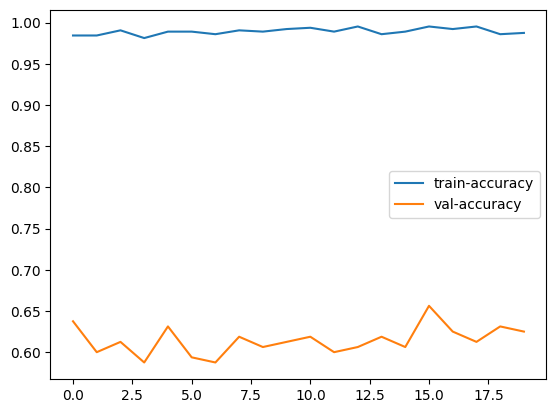

In [232]:
# plot learning curves
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train-accuracy')
plt.plot(history.history['val_accuracy'], label='val-accuracy')
plt.legend()
plt.show()

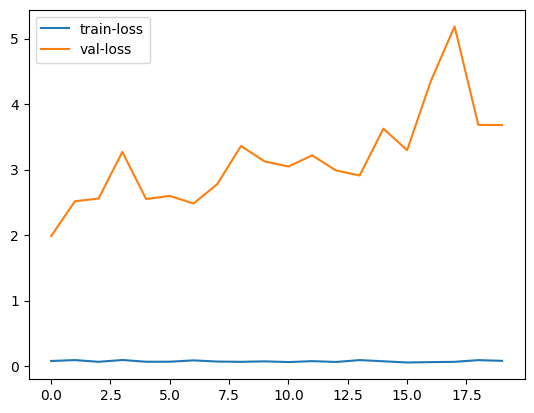

In [233]:
# Plot traning Loss and validation loss
plt.plot(history.history['loss'], label='train-loss')
plt.plot(history.history['val_loss'], label='val-loss')
plt.legend()
plt.show()

In [234]:
#Save the history in a file named accuracies.txt (loss, everthing)
with open('accuracies.txt', 'w') as f:
    
    # Save Training Loss
    f.write('Training Loss: ')
    f.write(str(history.history['loss']))
    f.write('\n')
    
    # Save Validation Loss
    f.write('\nValidation Loss: ')
    f.write(str(history.history['val_loss']))
    f.write('\n')
    
    # Save Training Accuracy
    f.write('\nTraining Accuracy: ')
    f.write(str(history.history['accuracy']))
    f.write('\n')
    
    # Save Validation Accuracy
    f.write('\nValidation Accuracy: ')
    f.write(str(history.history['val_accuracy']))
    f.write('\n')
    
    